In [1]:
# set up spark
import sys
from os import listdir
from os.path import join,exists
pyspark_home = '/opt/apache-spark/python/lib'
zipfiles = [join(pyspark_home, f) for f in listdir(pyspark_home) if f.endswith('.zip')]
sys.path += zipfiles
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
%pylab inline

path = '/home/gaoxiang/MEGA/tables'

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['isnan', 'cbrt', 'tanh', 'sum', 'log2', 'size', 'ceil', 'mean', 'split', 'cosh', 'randn', 'floor', 'log', 'repeat', 'expm1', 'sin', 'exp', 'cos', 'rank', 'hypot', 'trunc', 'tan', 'log1p', 'array', 'sinh', 'broadcast', 'log10', 'rand', 'sqrt', 'rint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


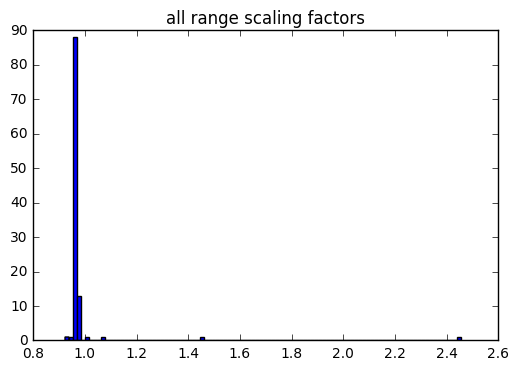

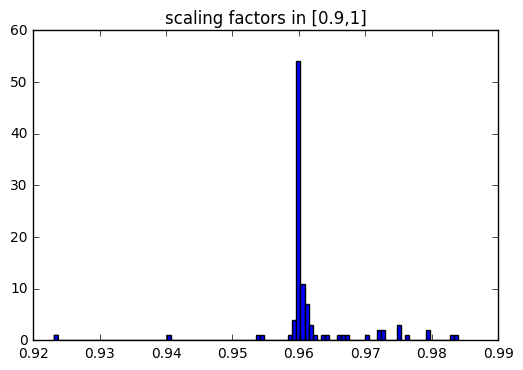

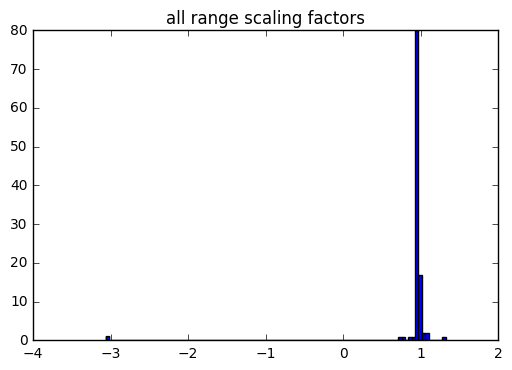

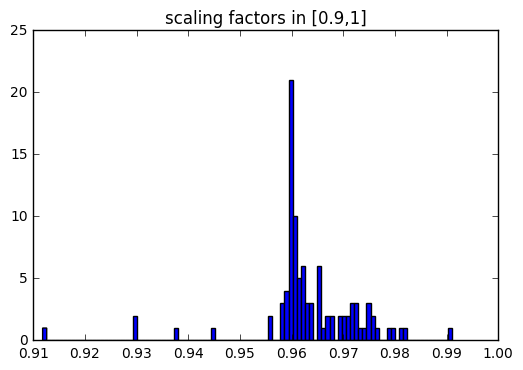

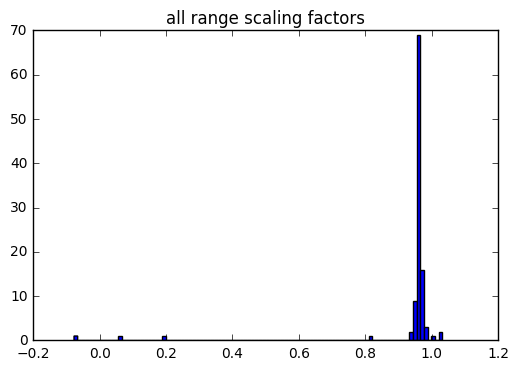

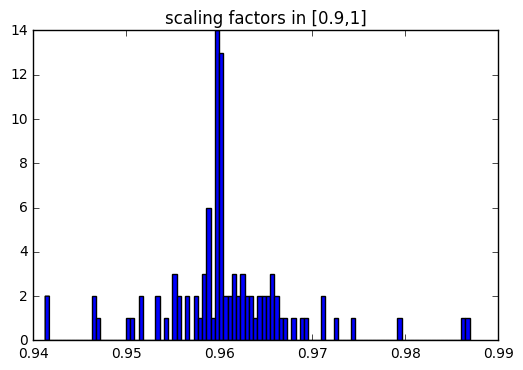

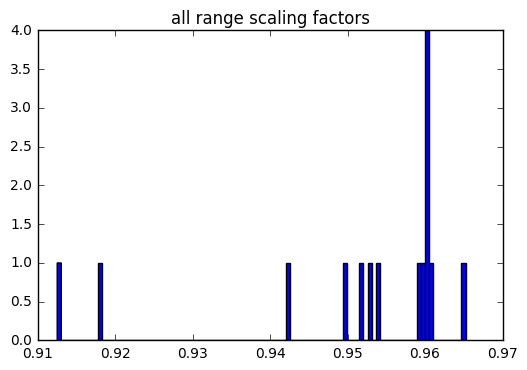

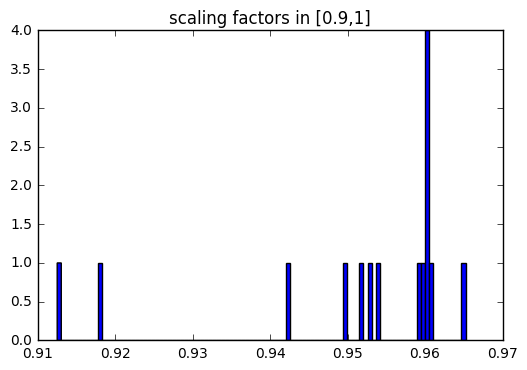

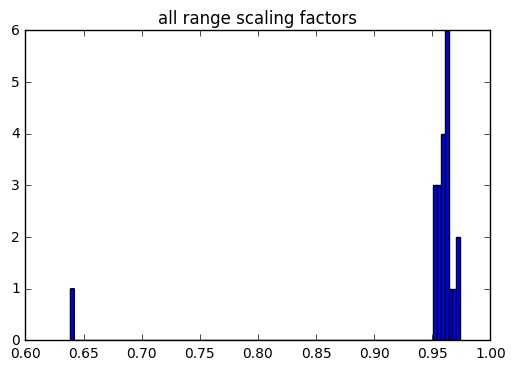

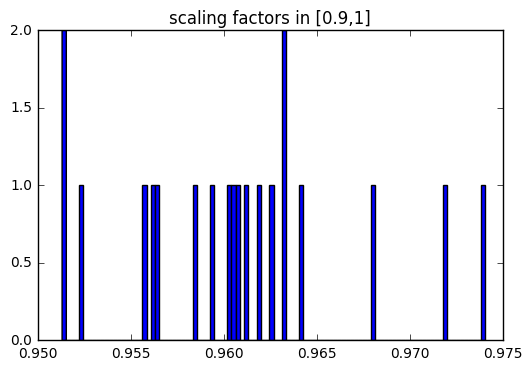

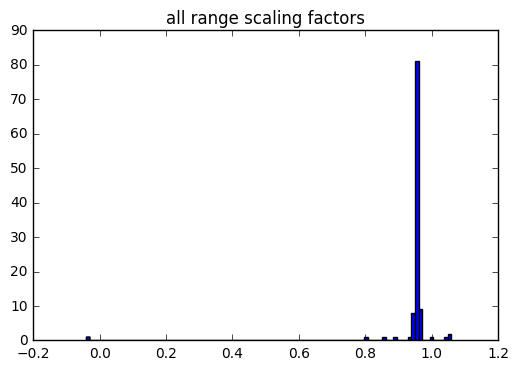

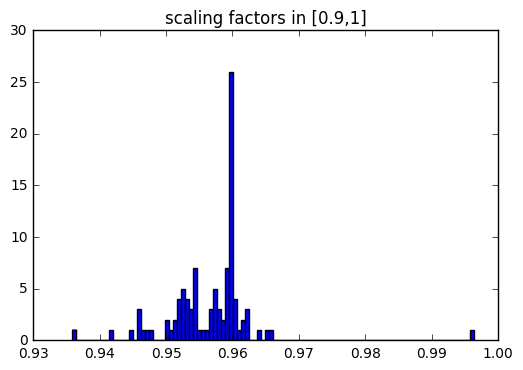

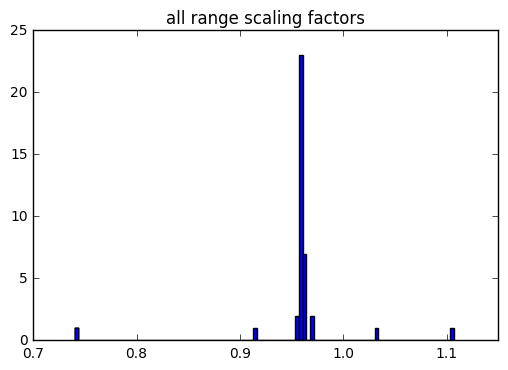

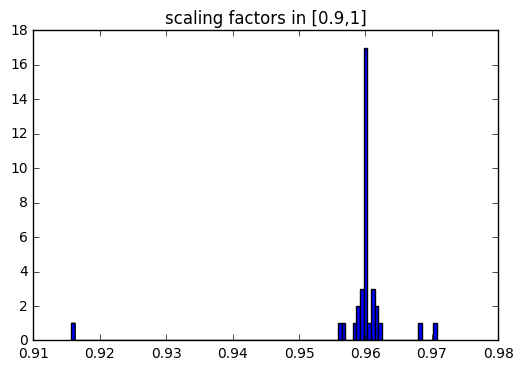

In [2]:
scalings = spark.read.parquet(path+'/scalings')
for i in range(len(scalings.take(1)[0]['value'])):
    scalingi = scalings.rdd.map(lambda x:x['value'][i]).filter(lambda x:x!=0.96)
    c = scalingi.collect()
    fig,ax = plt.subplots()
    plt.hist(c,100)
    plt.title("all range scaling factors")
    plt.show()
    scalingif = scalingi.filter(lambda x:x>0.9 and x<1)
    c = scalingif.collect()
    plt.hist(c,100)
    plt.title("scaling factors in [0.9,1]")
    plt.show()

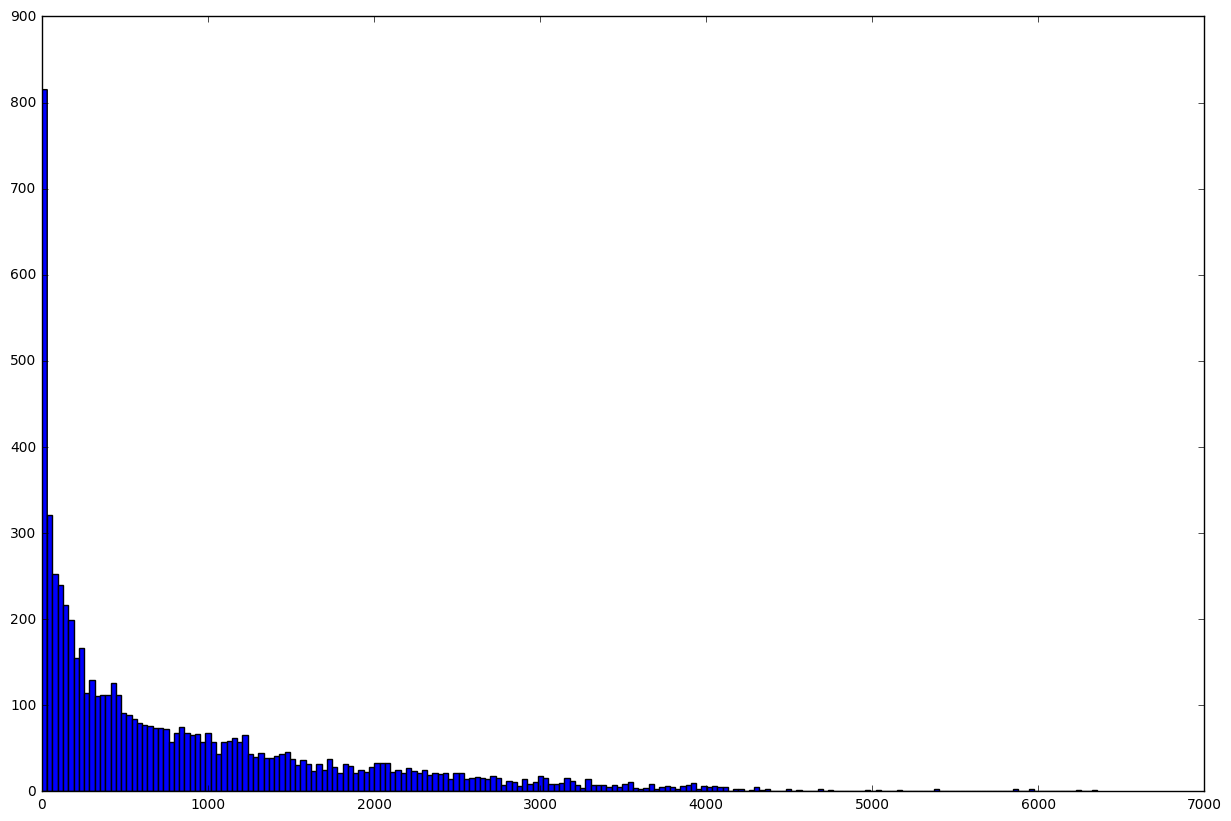

+----+-----+
|rank|count|
+----+-----+
|   0|   85|
|   1|   66|
|   2|   43|
|   3|   41|
|   4|   28|
|   5|   27|
|   6|   36|
|   7|   23|
|   8|   26|
|   9|   32|
|  10|   20|
|  11|   18|
|  12|   24|
|  13|   17|
|  14|   21|
|  15|   19|
|  16|   17|
|  17|   18|
|  18|   14|
|  19|   20|
+----+-----+
only showing top 20 rows



In [3]:
distances = spark.read.parquet(path+'/distances')
ranks = distances.select('rank')
local = ranks.collect()
rank = [row['rank'] for row in local]
fig,ax = plt.subplots()
plt.hist(rank,200)
fig.set_size_inches(15, 10)
plt.show()
ranks.groupBy('rank').count().sort('rank').show()

+---------+--------------------+----+---------+--------------------+--------------------+
|      mid|              smiles|rank|rankrange|              expvec|               thvec|
+---------+--------------------+----+---------+--------------------+--------------------+
|  C590192|              C=C=CC|   0|        0|[6.83633988349585...|[0.02021741865503...|
|  C756025|    C=CC(C)(C)C(=C)C|   1|        1|[9.47295056755170...|[0.17895723104781...|
| C5785660|OC(c1ccccc1)(c1cc...|   2|        2|[0.03082285156388...|[0.55002920996267...|
|  C103059|  CC(C)(O)CCc1ccccc1|   4|        3|[0.06436762924444...|[0.19228274664697...|
|   C91634|     Cc1ccc2ccccc2n1|   8|        4|[0.01970452039235...|[0.06496589742544...|
| C2741380|C=CCP(c1ccccc1)c1...|  12|        5|[0.01419458361991...|[0.49938715688028...|
|  C926567|          C=CC=C(C)C|  29|        6|[0.00428878212818...|[0.88935334929770...|
| C5715231|       CC1CCC(O)CC1C|  33|        7|[2.56244884520251...|[0.02705576218936...|
|  C613978

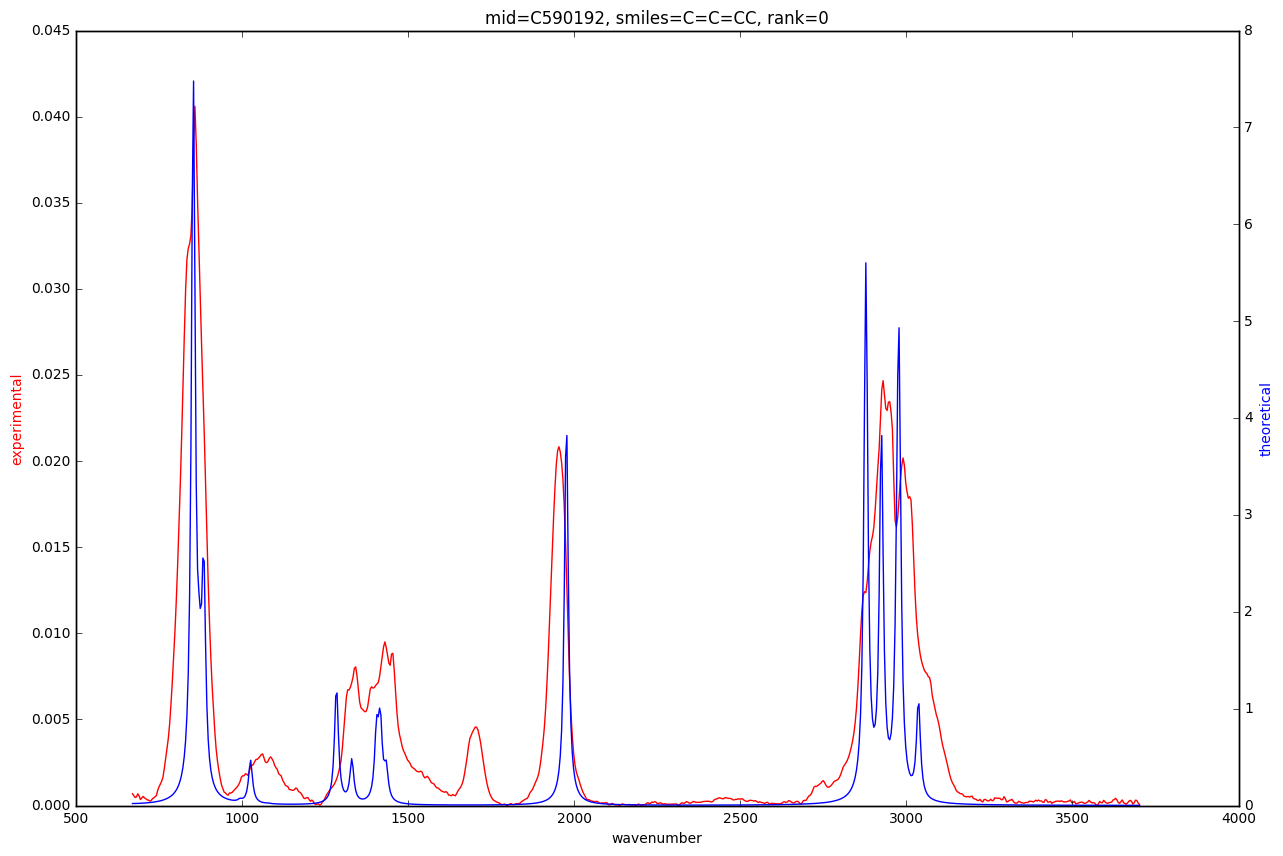

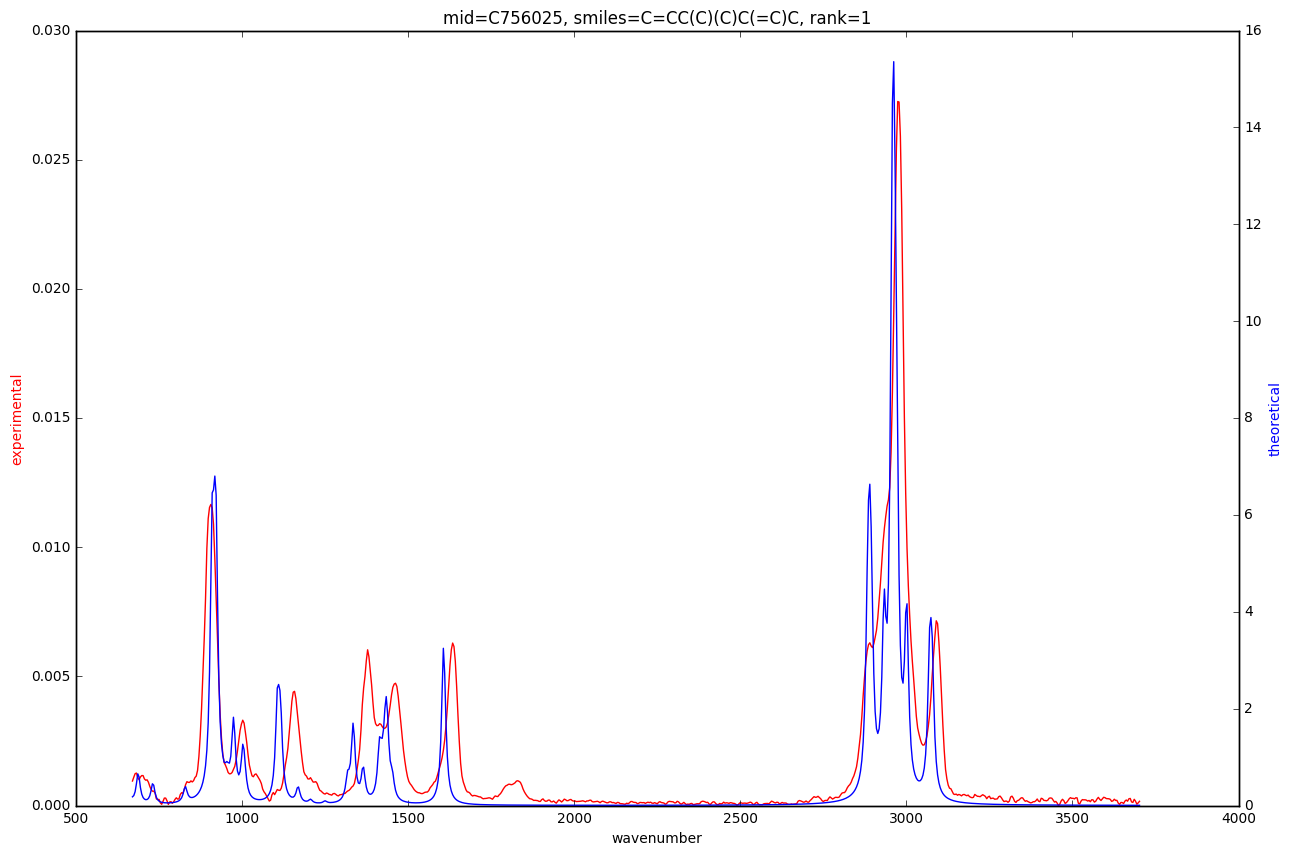

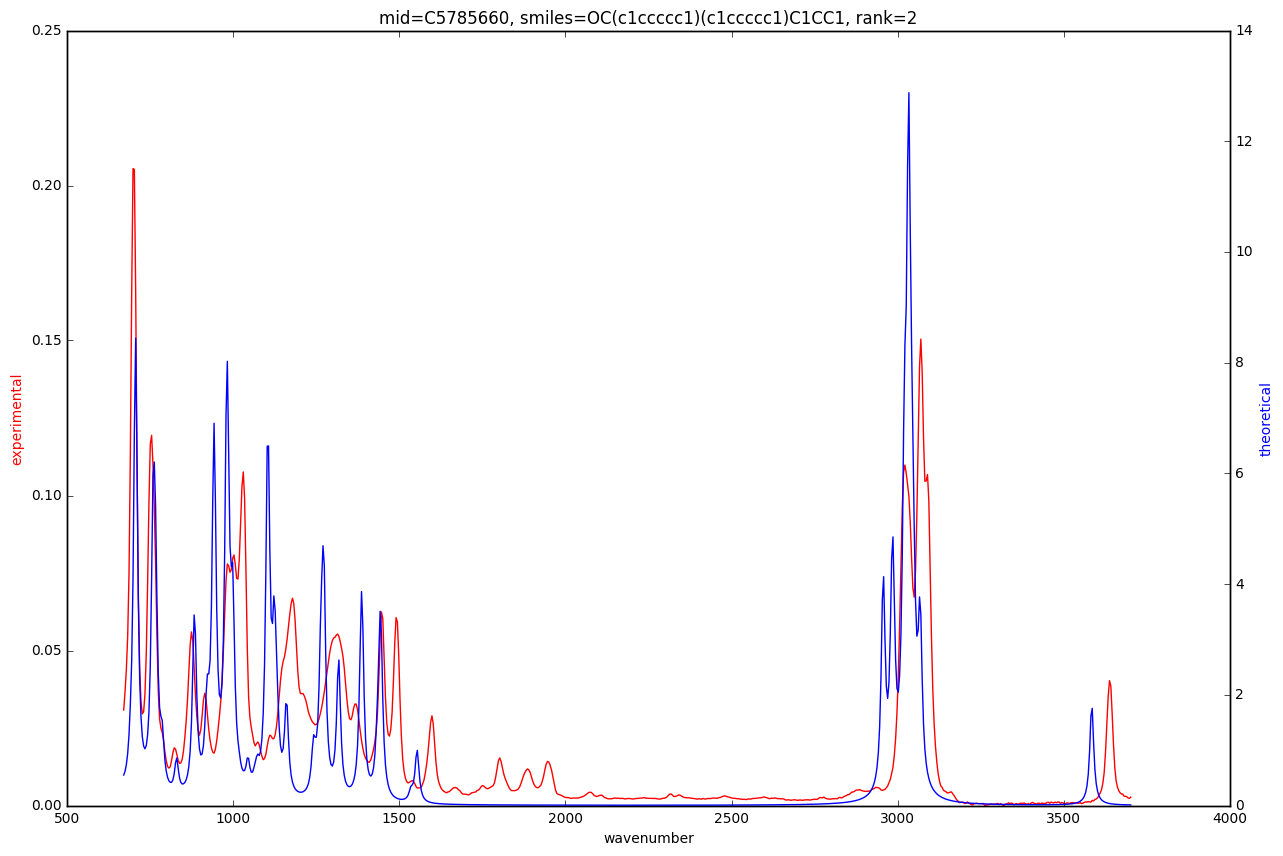

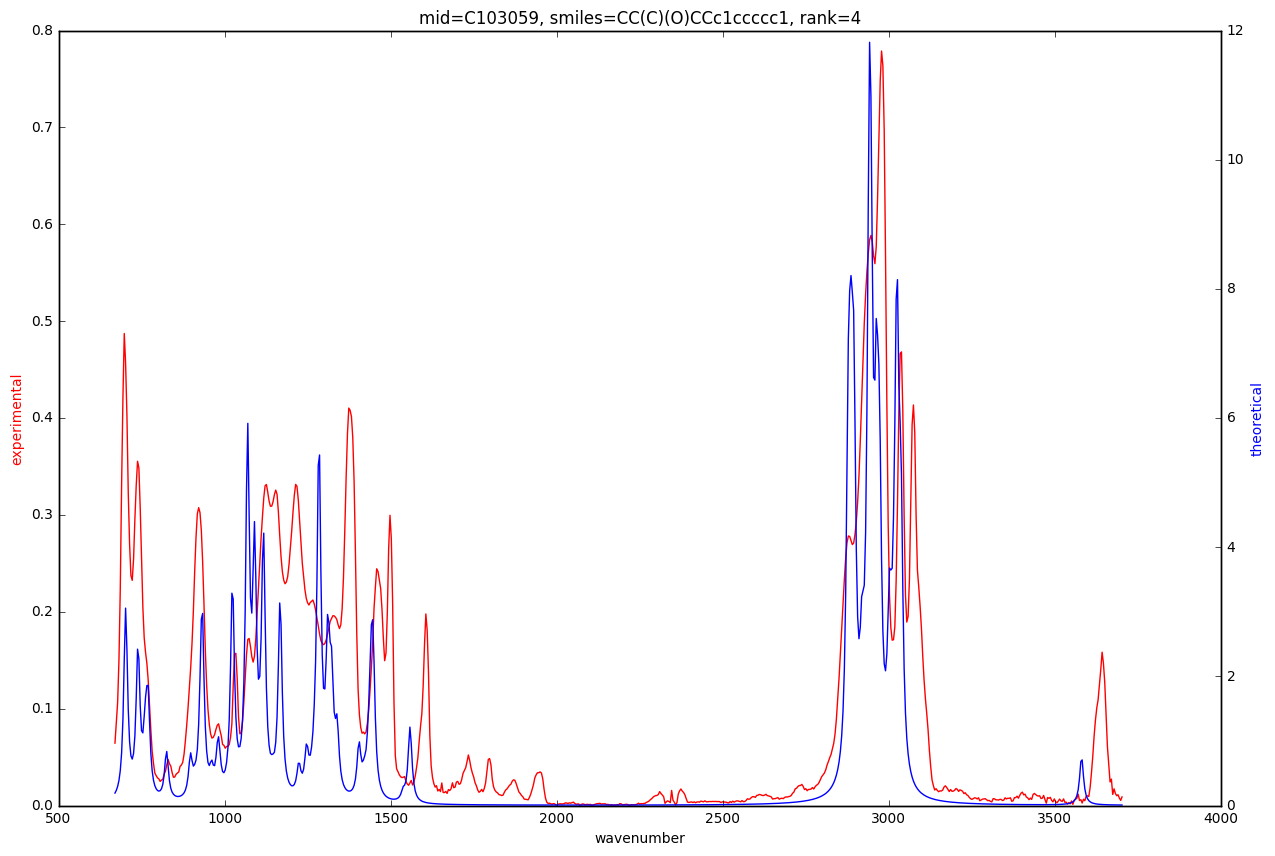

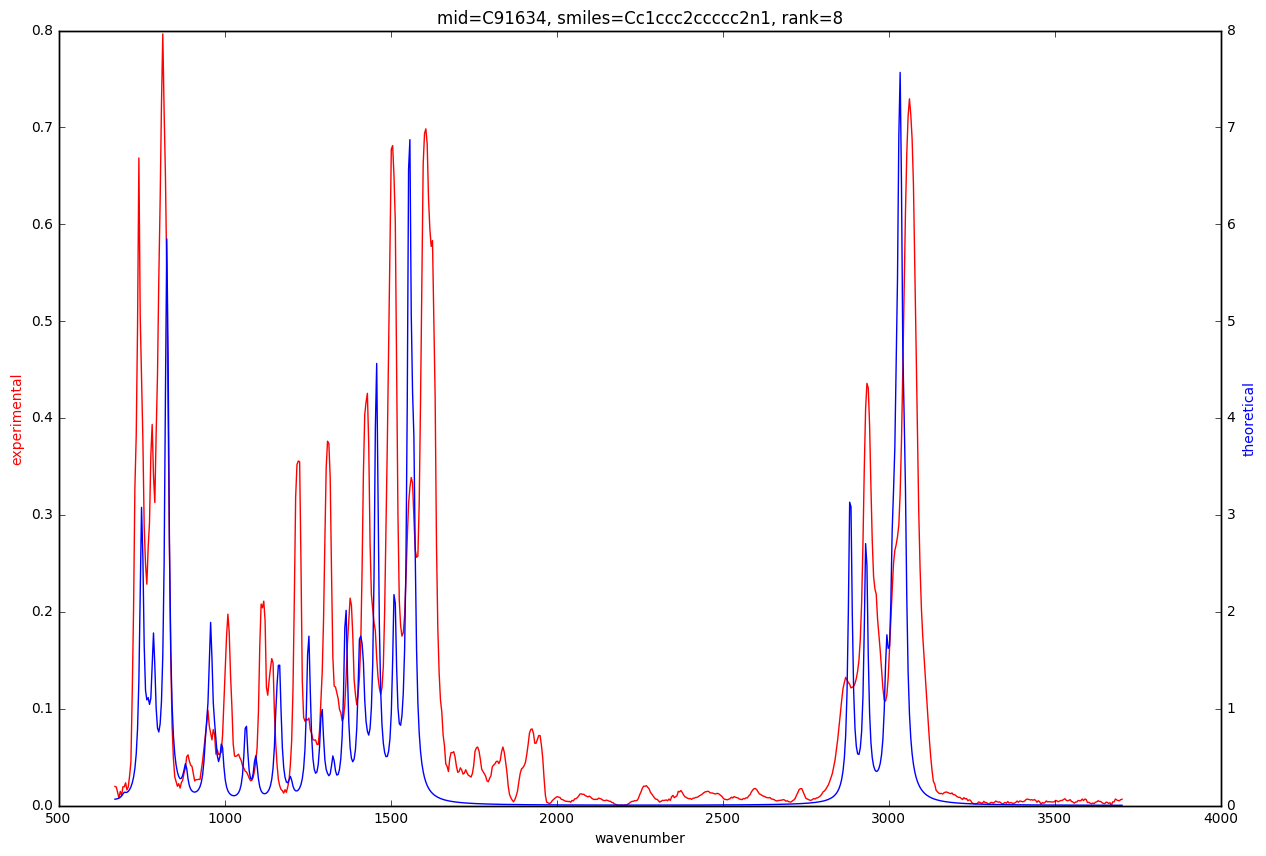

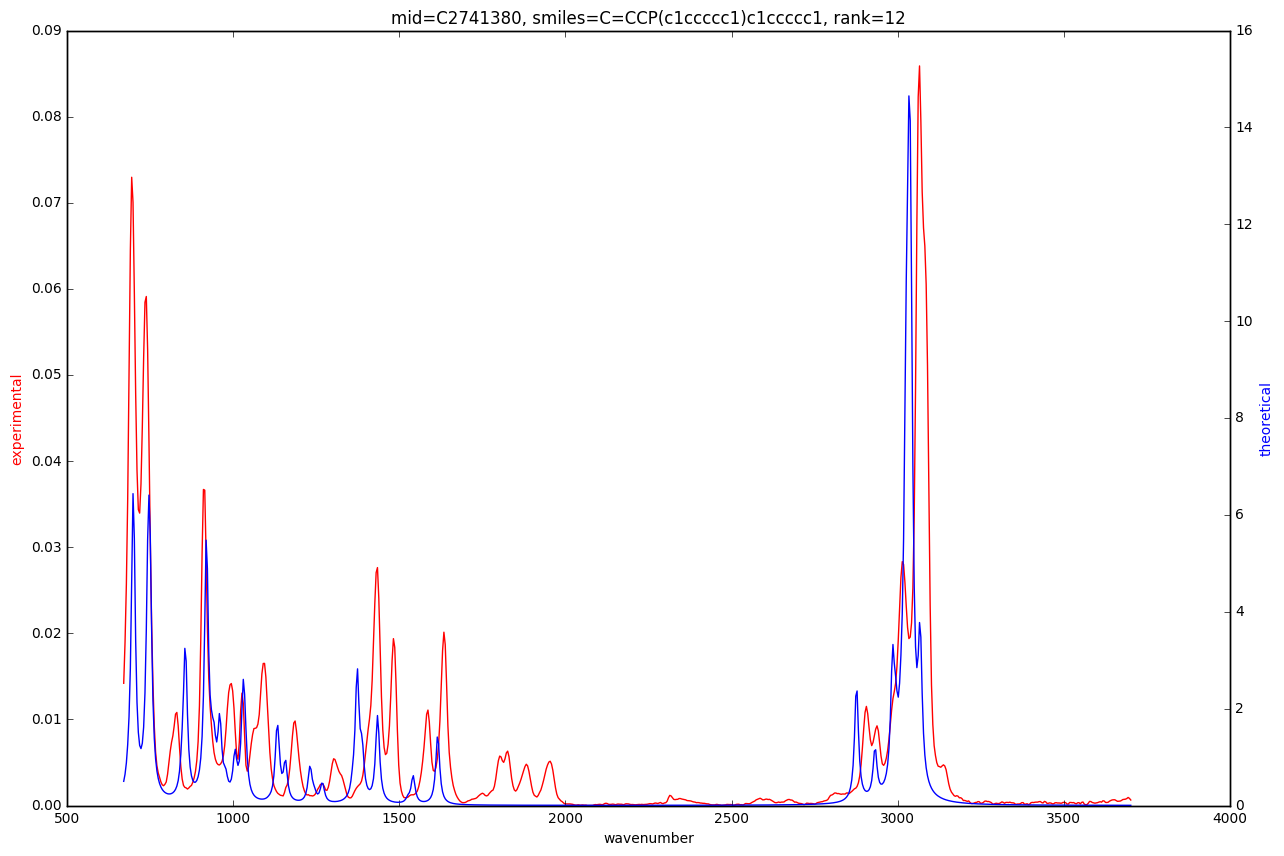

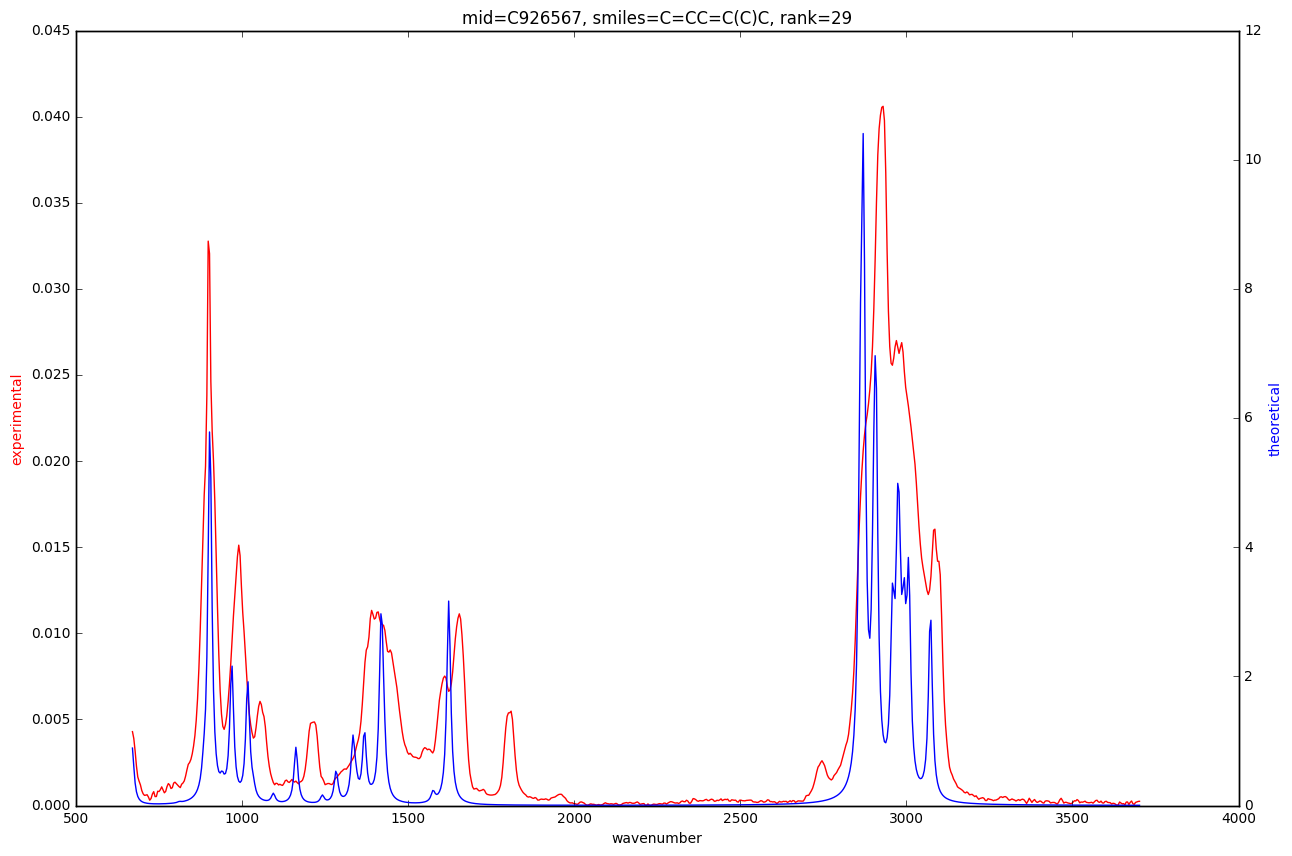

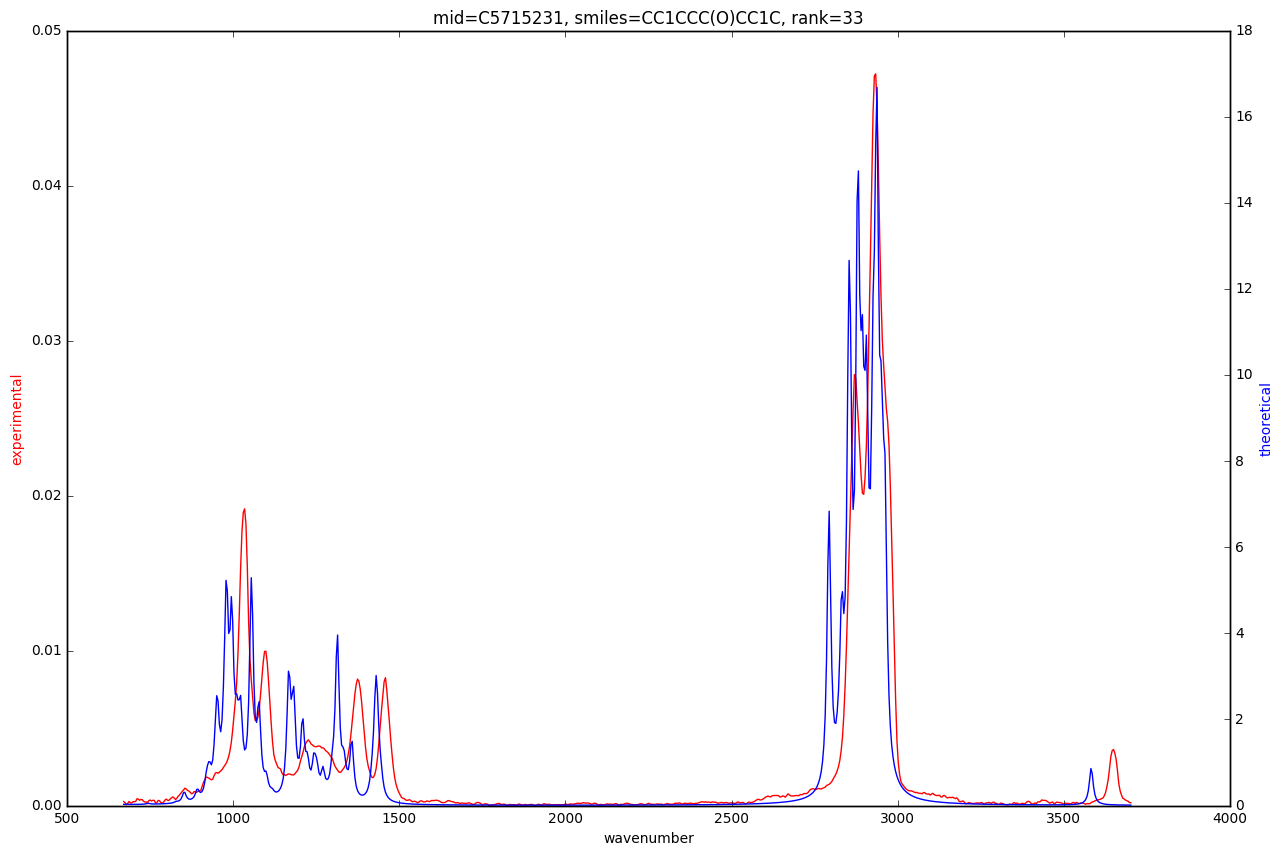

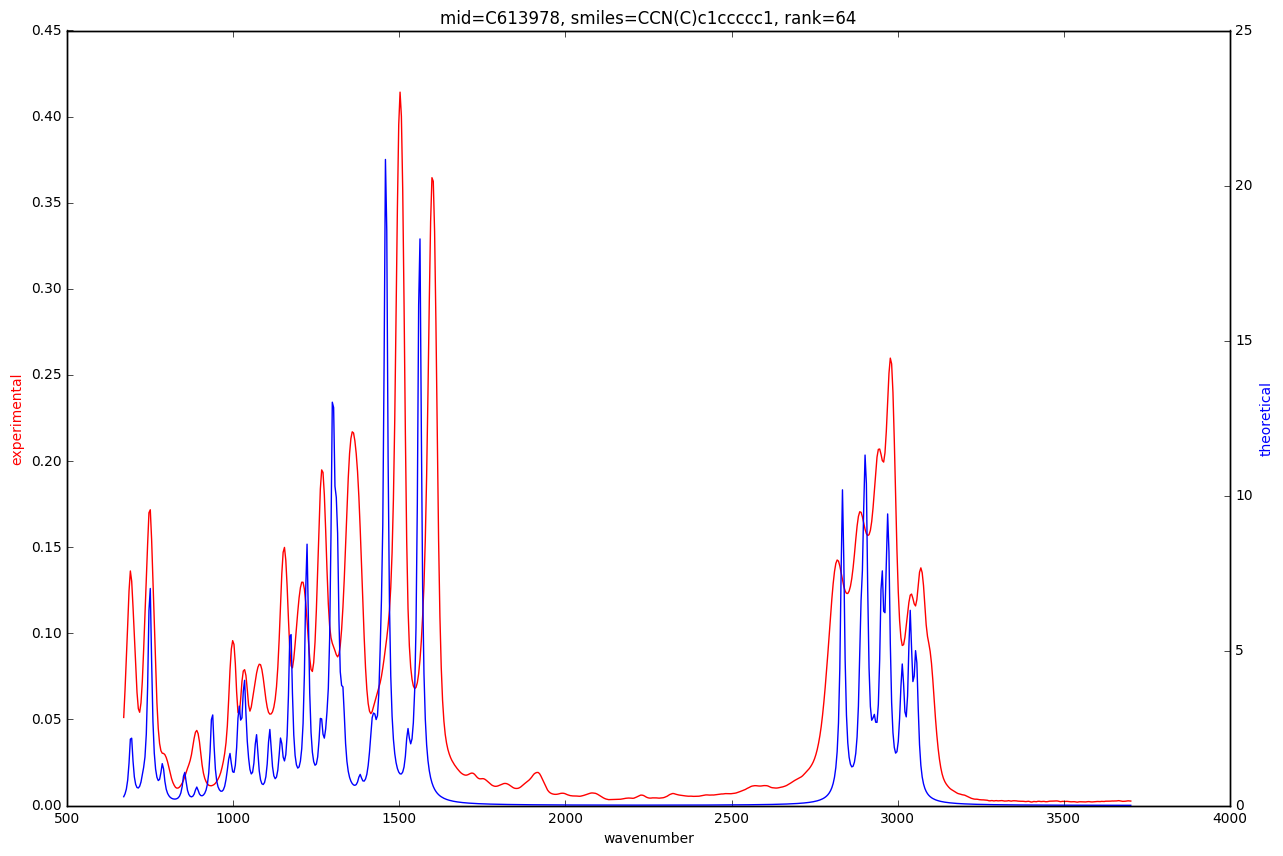

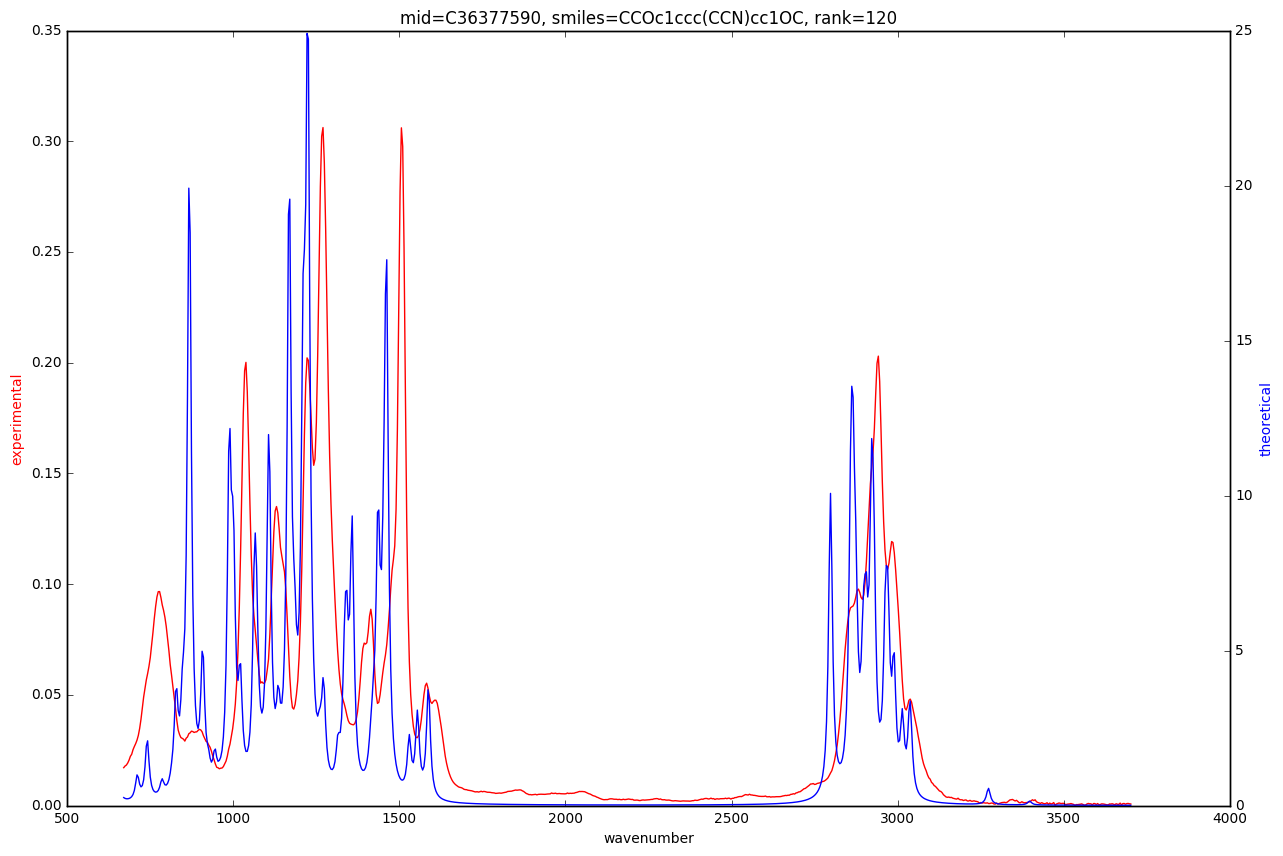

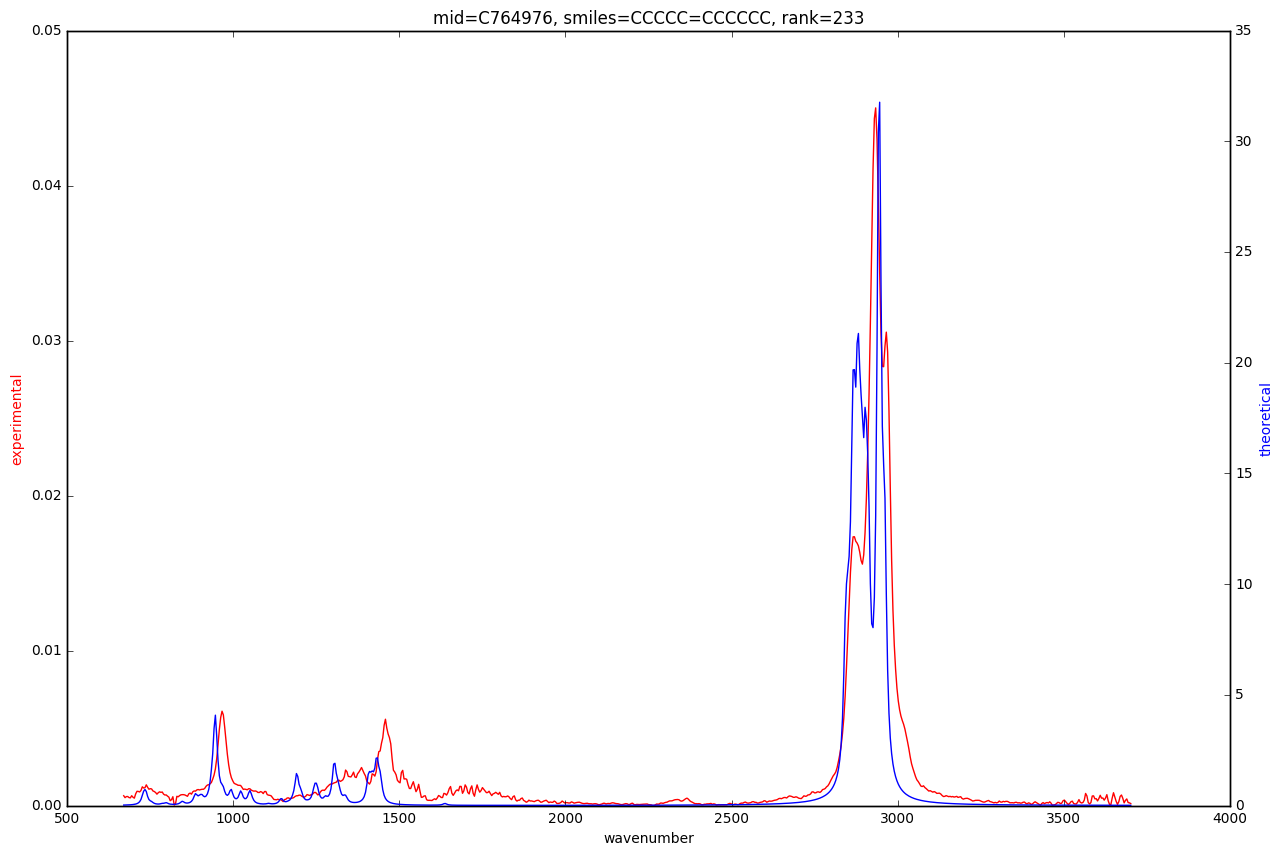

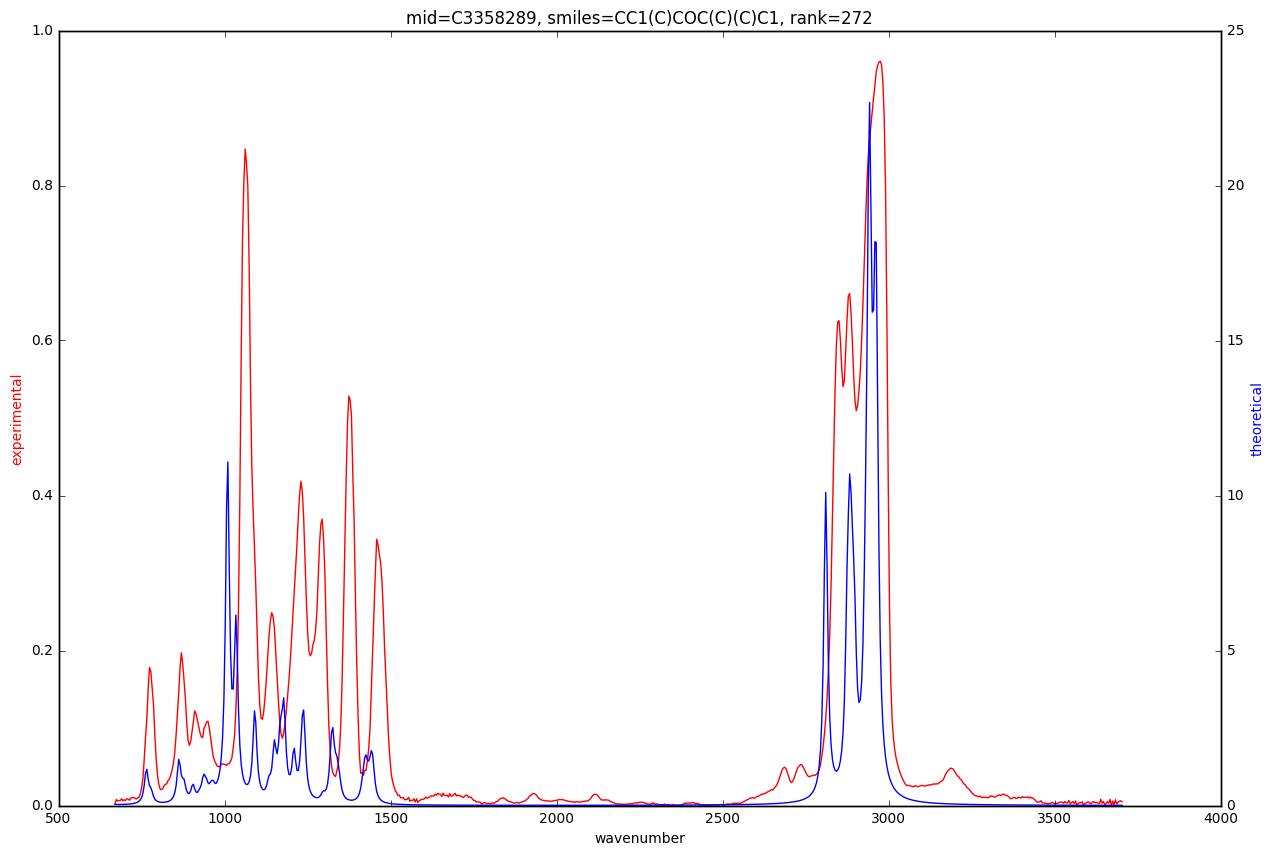

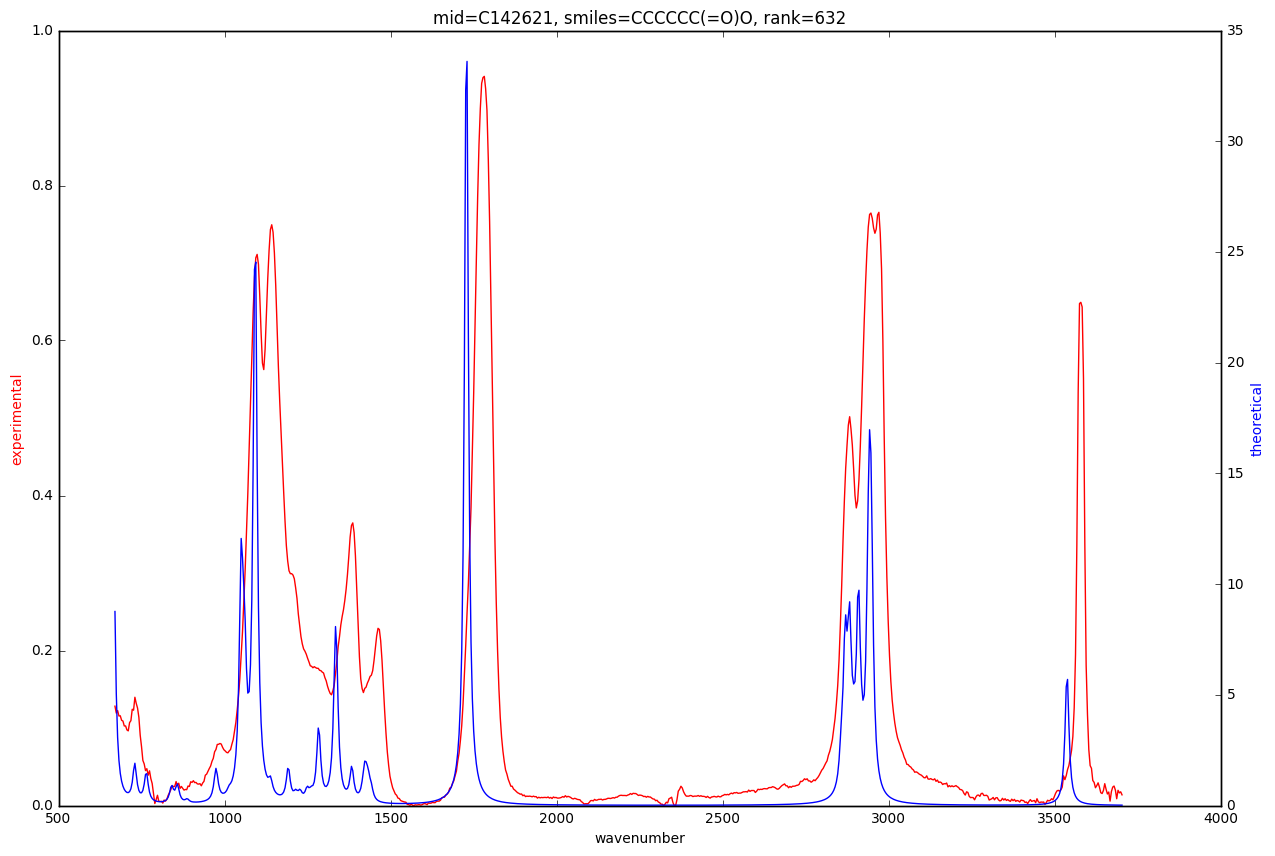

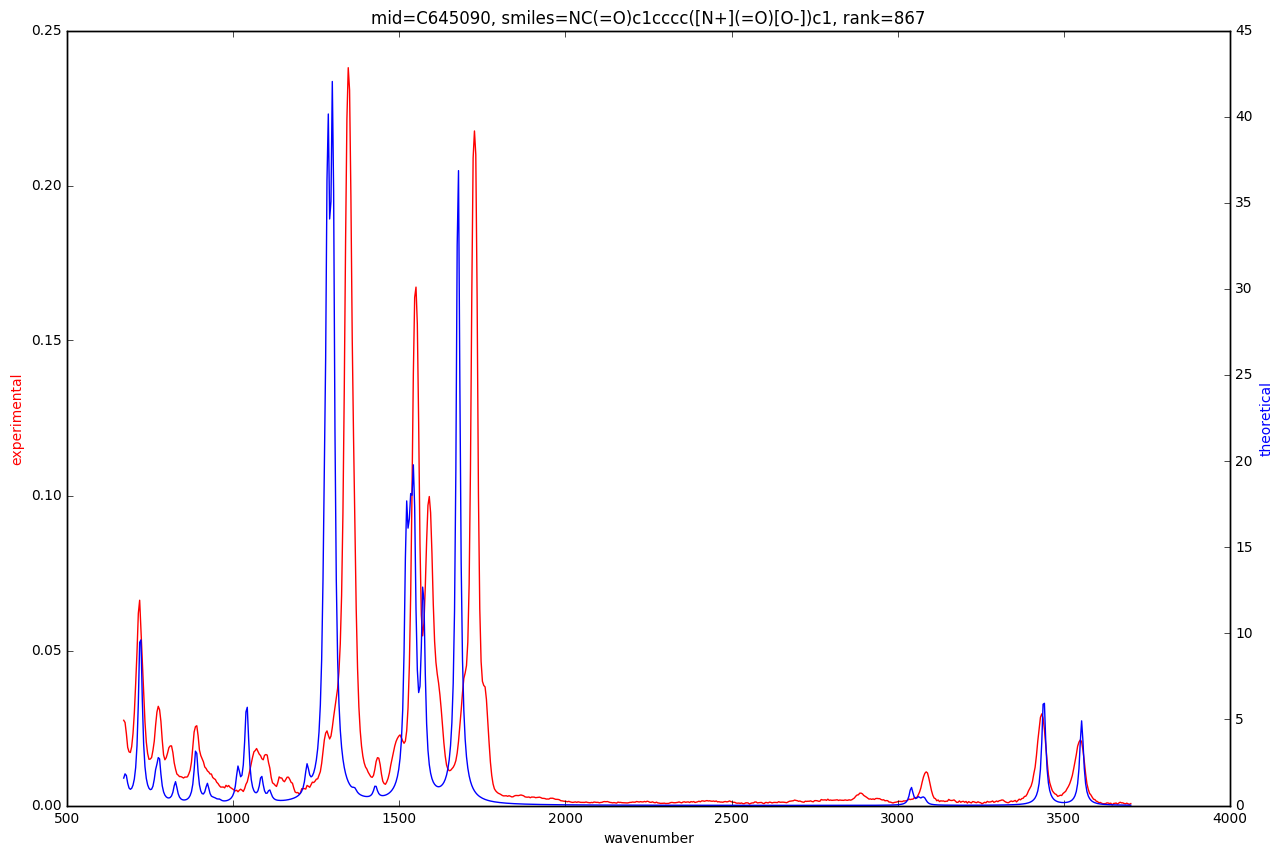

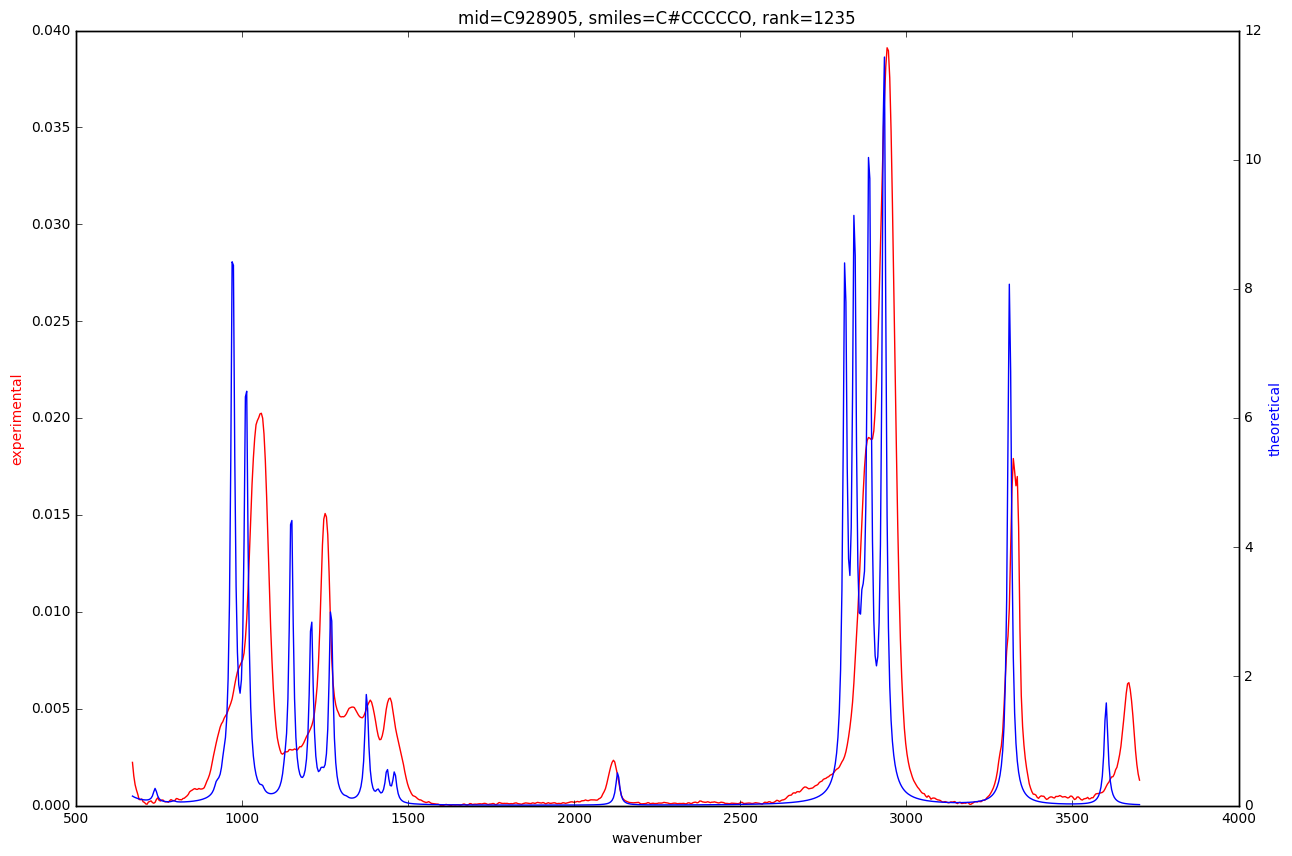

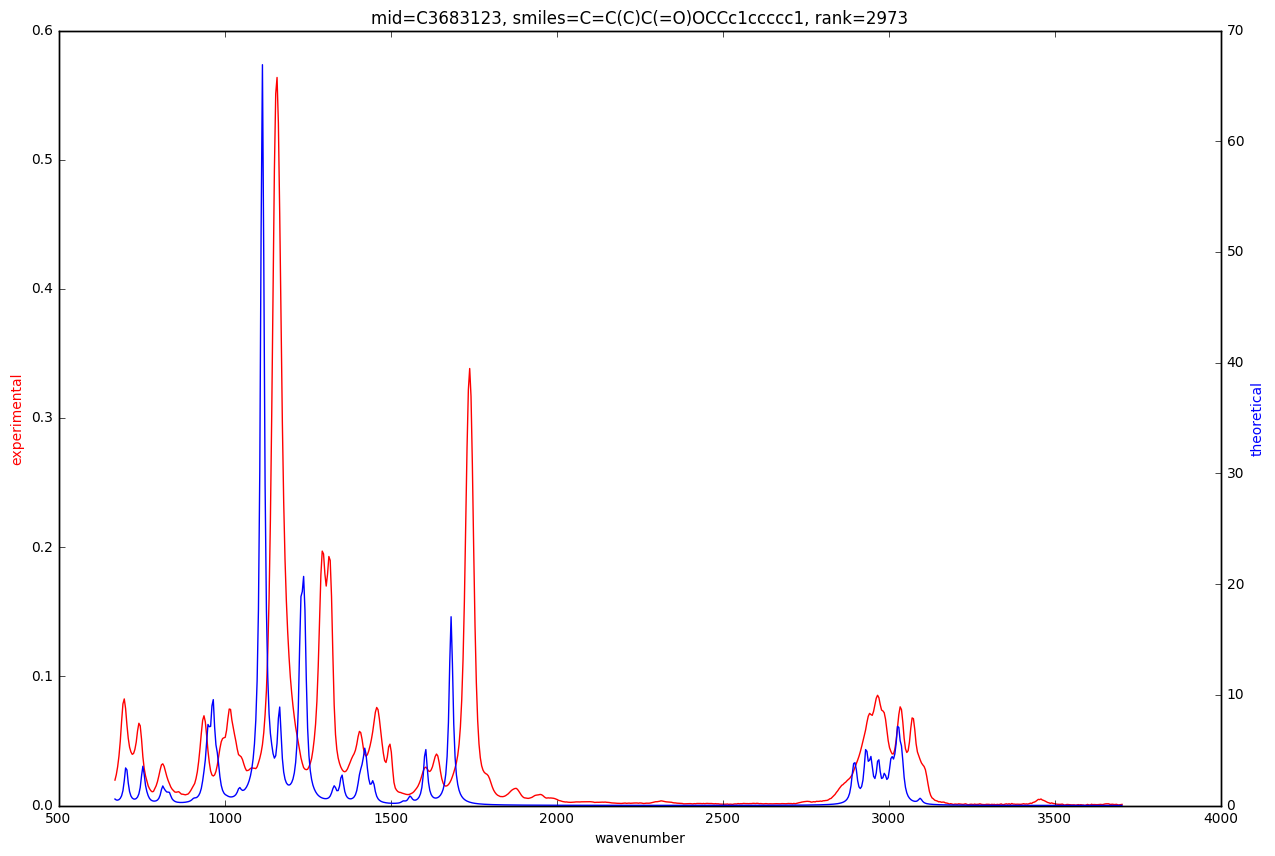

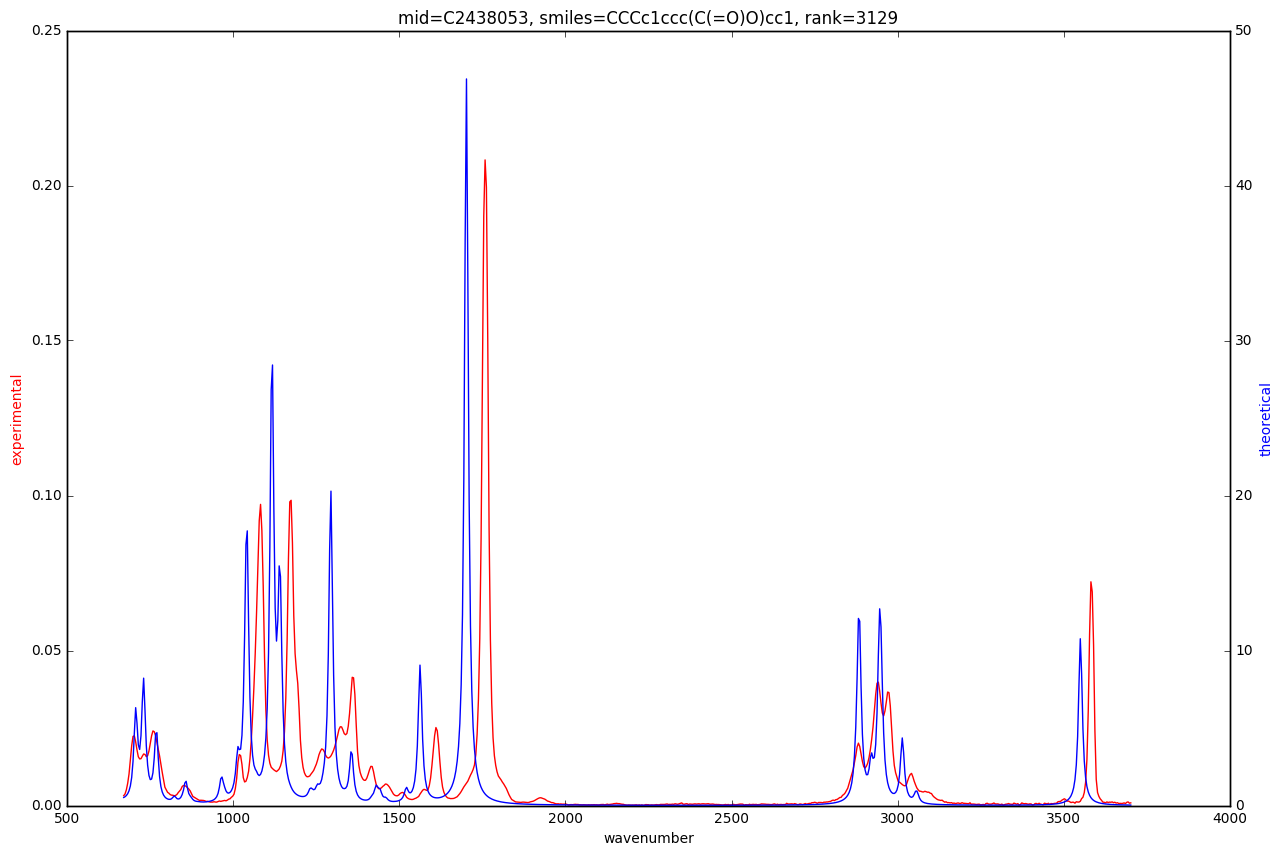

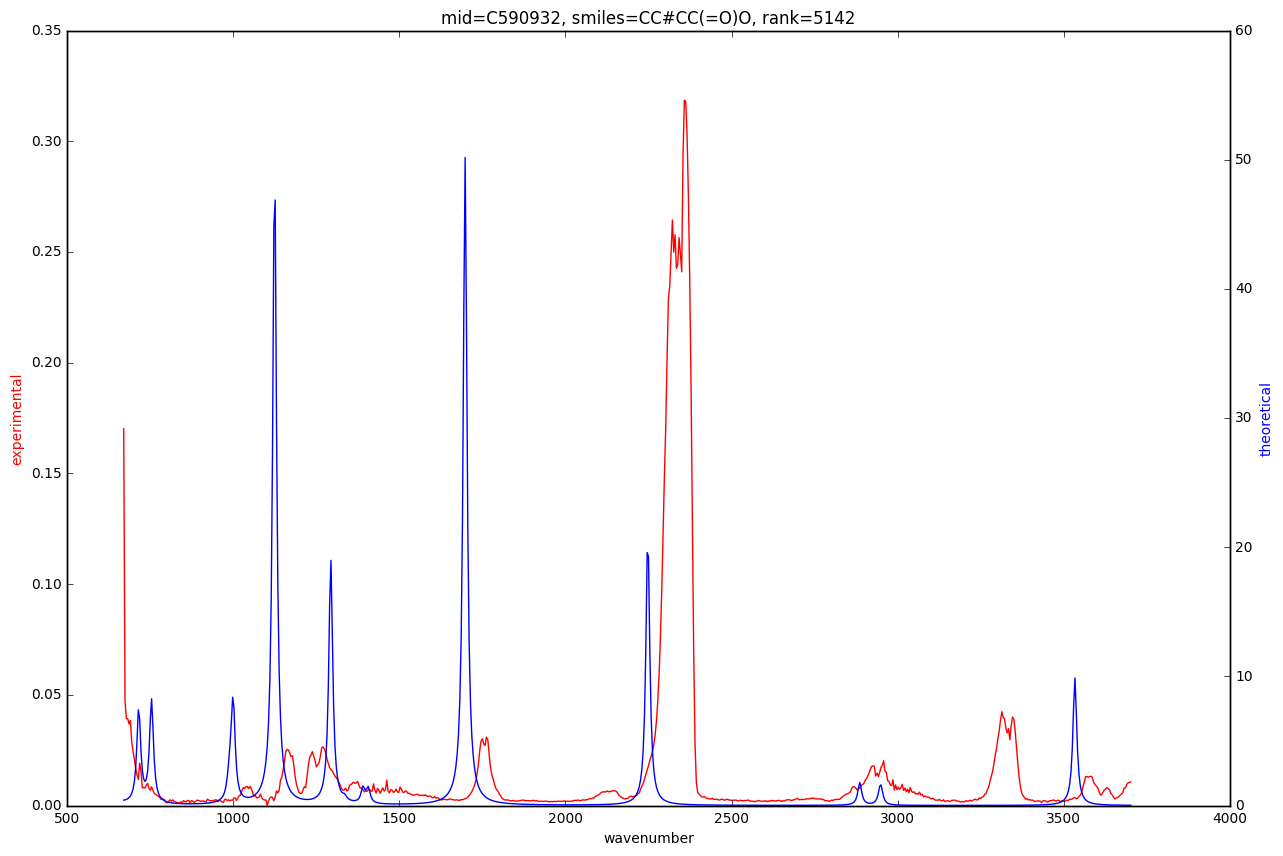

In [4]:
# get good and bad examples
thexpvec = spark.read.parquet(path+'/thexpvec')
disvec = thexpvec.join(distances.withColumnRenamed('exp_smiles','smiles'),'smiles') \
                 .select('mid','smiles','rank','expvec','thvec') \
                 .dropDuplicates(['smiles'])
selected = disvec.select('mid','smiles','rank',expr('int(2*log(1+rank))').alias('rankrange'),'expvec','thvec')\
                 .dropDuplicates(['rankrange']).sort('rankrange')
selected.show()


# plot
local = selected.collect()
xs = range(670,3706,4)
for row in local:
    mid = row['mid']
    smiles = row['smiles']
    rank = row['rank']
    expvec = row['expvec']
    thvec = row['thvec']
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel('wavenumber')
    ax1.set_ylabel('experimental', color='r')
    ax2.set_ylabel('theoretical', color='b')
    plt.title("mid={}, smiles={}, rank={}".format(mid,smiles,rank))
    ax1.plot(xs,expvec,'r',label='experimental')
    ax2.plot(xs,thvec,'b',label='theoretical')
    fig.set_size_inches(15, 10)
    plt.show()